# CNN

## Imports

In [1]:
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../modules'))
import notebook_loading

from CNN_Train import CNN_Train
from CNN_Data import *
from CN_Network import CN_Network

importing Jupyter notebook from CNN_Train.ipynb
importing Jupyter notebook from CNN_Data.ipynb
importing Jupyter notebook from CN_Network.ipynb


## Load & Setup Data

In [2]:
# extract the redundant baselines and their gains and data from miriad and calfits files
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

# seperate trining and testing redundant baselines 
# if we have not already done this, load them from disk
training_redundant_baselines_dict, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())

# seperate the visiblites
training_baselines_data = get_seps_data(training_redundant_baselines_dict, uvd)
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

## Trainer

In [3]:
trainer = CNN_Train()

In [4]:
trainer.add_data((training_baselines_data, training_redundant_baselines_dict),
                 (testing_baselines_data, testing_redundant_baselines_dict),
                 gains)

## Network

In [5]:
wide_filter_widths = [64,32,8]
width_reduction_factors = [2,3,4]
learning_rate = 0.0001

example_network_A = CN_Network(name = 'example_network_A',
                             wide_filter_widths = wide_filter_widths,
                             width_reduction_factors = width_reduction_factors,
                             learning_rate = learning_rate)
example_network_A.print_params()

{'cost_name': 'MSE',
 'dtype': tf.float32,
 'g_shift': 0.01,
 'learning_rate': 0.0001,
 'name': 'example_network_A',
 'num_freq_channels': 1024,
 'threshold': 0.00625,
 'wide_filter_widths': [64, 32, 8],
 'width_reduction_factors': [2, 3, 4]}


In [6]:
trainer.network = example_network_A
trainer.num_epochs = 20
trainer.model_save_interval = 5# quick example
trainer.train()

Training Finished


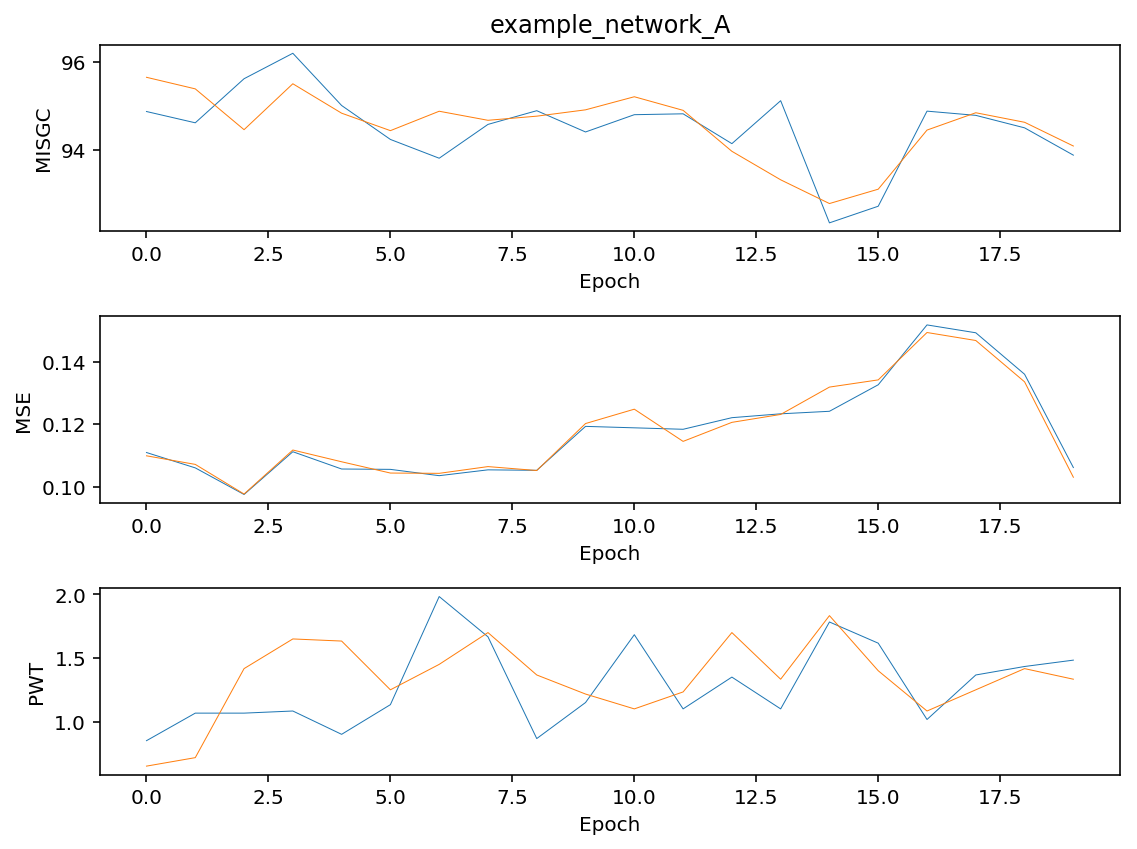

In [7]:
trainer.plot()